In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import matplotlib.pyplot as plt
from muon import atac as ac
from muon import prot as pt
import anndata as ad
import seaborn as sns
import random
import os
import scipy
from scipy.stats import median_abs_deviation


In [2]:
adata = sc.read_10x_mtx('/Users/alexandra/Desktop/Data/Single-Cell/hg19_10xCloud_aligned_data/filtered_feature_bc_matrix', gex_only = False)

gex_rows = list(map(lambda x: x == 'Gene Expression', adata.var['feature_types']))
atac_rows = list(map(lambda x: x == 'Peaks', adata.var['feature_types']))

adata_gem = adata[:, gex_rows].copy()
adata_atac = adata[:, atac_rows].copy()

adata_gem.var_names_make_unique()
adata_atac.var_names_make_unique()

In [3]:
# mitochondrial genes
adata_gem.var["mt"] = adata_gem.var_names.str.startswith("MT-")
# ribosomal genes
adata_gem.var["ribo"] = adata_gem.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gem.var["hb"] = adata_gem.var_names.str.contains("^HB[^(P)]")

In [4]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(
    adata_gem, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_gem

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 11112 × 20346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

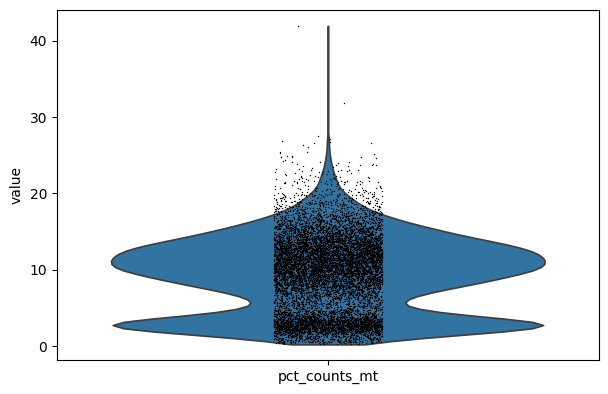

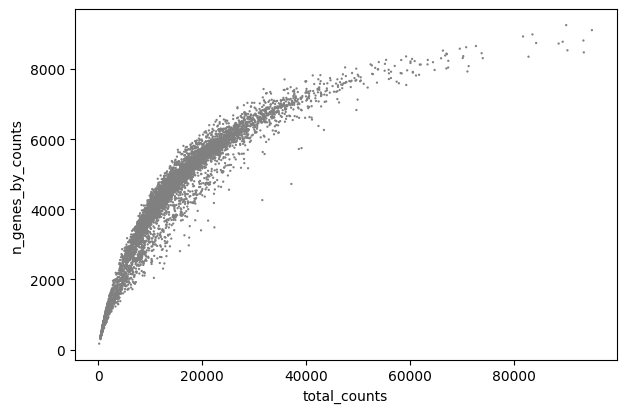

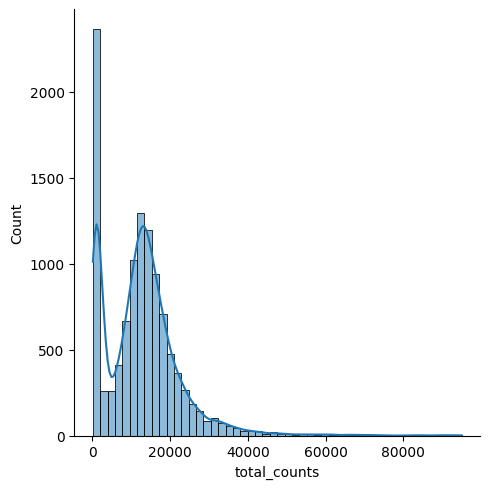

In [5]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [6]:
# filter cells by MADs
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M )
    return outlier 

In [7]:
# filter cells by MADs
adata_gem.obs["outlier"] = (
    is_outlier(adata_gem, "total_counts", 5)
  | is_outlier(adata_gem, "n_genes_by_counts", 5)
)

adata_gem.obs.outlier.value_counts()

outlier
False    10937
True       175
Name: count, dtype: int64

In [8]:
adata_gem.obs["mt_outlier"] = adata_gem.obs["pct_counts_mt"] > 20
adata_gem.obs.mt_outlier.value_counts()

mt_outlier
False    10957
True       155
Name: count, dtype: int64

In [9]:
adata_gem = adata_gem[~adata_gem.obs["outlier"] & ~adata_gem.obs.mt_outlier].copy()
adata_gem

AnnData object with n_obs × n_vars = 10791 × 20346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

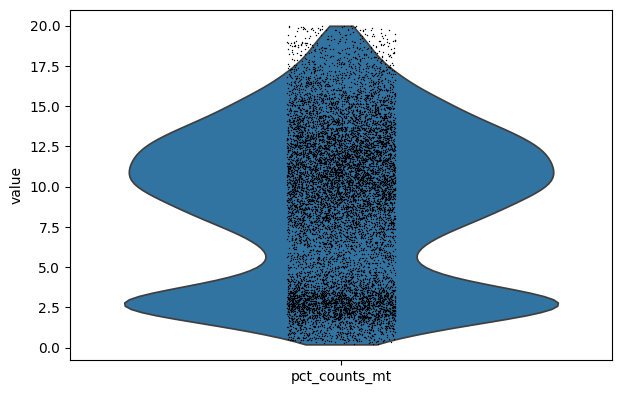

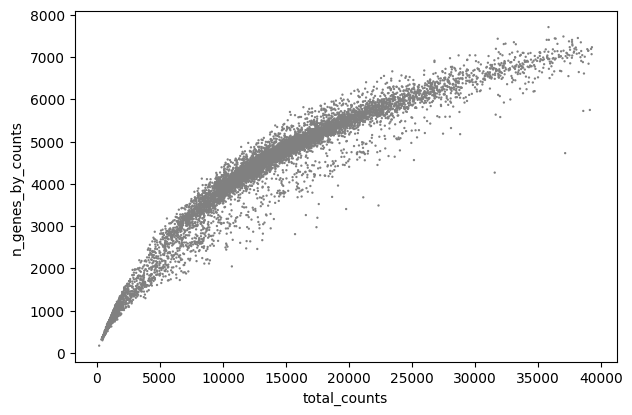

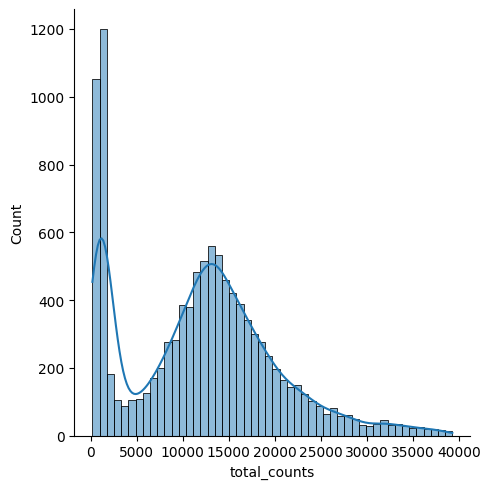

In [10]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [ ]:
# Optional: keep total validation gene
valid_csv = pd.read_excel("/Users/alexandra/Desktop/Data/CRISPRiFlowFISH/41588_2019_538_MOESM3_ESM.xlsx",  sheet_name="Supplementary Table 6a", skiprows=1)
valid_gene_list = set(valid_csv["Gene"])
len(valid_gene_list)

/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


65

In [ ]:
# Optional: keep only CRIPRIi-FlowFISH validation gene
valid_csv = pd.read_excel("/Users/alexandra/Desktop/Data/CRISPRiFlowFISH/41588_2019_538_MOESM3_ESM.xlsx",  sheet_name="Supplementary Table 3a", skiprows=1)
valid_gene_list = set(valid_csv["Gene"])
len(valid_gene_list)

/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


30

In [60]:
valid_gene_data = adata_gem[:,pd.Index(valid_gene_list)]

In [11]:
# fitler genes
sc.pp.filter_genes(adata_gem, min_cells=20)
adata_gem = adata_gem[:,~adata_gem.var["mt"]& ~adata_gem.var["ribo"] & ~adata_gem.var["hb"]].copy()
adata_gem

AnnData object with n_obs × n_vars = 10791 × 13703
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [12]:
# Normalization
sc.pp.normalize_total(adata_gem, target_sum=1e6)
sc.pp.log1p(adata_gem)

In [ ]:
# Select highly variable genes



In [ ]:
# Optional: add validation genes back
adata_gem = ad.concat([adata_gem, valid_gene_data], axis=1, join="outer")
